In [2]:
import sys
import os
import numpy as np
import skaero
import pyperclip
from skaero.atmosphere import coesa
import matplotlib.pyplot as plt
import h5py

print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('Python version: ' + sys.version)
print('Numpy version: ' + np.version.version)
print('Scikit-Aero version: ' + skaero.__version__)
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Numpy version: 1.16.2
Scikit-Aero version: 0.1
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [15]:
r = h5py.File('ld0.3.h5')
list(r.keys())

['INDEX', 'NASTRAN']

In [31]:
el = r['NASTRAN']['INPUT']['ELEMENT']['CQUAD4']
el[0]

(1, 3, [1, 2, 5, 4], 0., 0., 0, [-1., -1., -1., -1.], -1, 1)

In [3]:
h, T, p, rho = coesa.table(1000)

print('At {} m, the temperature is {} K, the ambient pressure is {:.2f} kPa, and the density is {:.3} kg/m3.'.format(h, T, p/1000, rho))

At 1000 m, the temperature is 281.65 K, the ambient pressure is 89.87 kPa, and the density is 1.11 kg/m3.


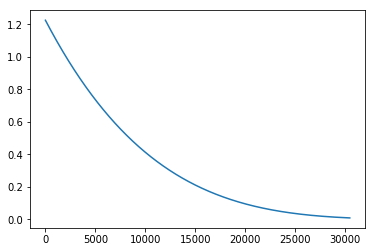

In [3]:
h = np.linspace(0, 30480, num=1000)
h, T, p, rho = coesa.table(h)
fig, ax = plt.subplots()
ax.plot(h, rho)

In [4]:
# Dynamic Pressure on an object

# Velocity, in m/s
u = 50

# Altitude, in m
h = 1000

# Density and Temperature calculated based on the US Standard Atmosphere
h, T, p, rho = coesa.table(h)

# Dynamic Pressure, in Pa (N*m^-2)
q = 0.5*rho*u**2

In [5]:
h = np.array([10, 100, 1000, 10000])

h, T, p, rho = coesa.table(h)
print(rho)

q = 0.5*rho*u**2

for alt,den in zip(h,q):
    print('At {:.0f}m, dynamic pressure is {:.2E}Pa.'.format(alt, den))

[1.22382355 1.21328194 1.11164181 0.41270625]
At 10m, dynamic pressure is 1.53E+03Pa.
At 100m, dynamic pressure is 1.52E+03Pa.
At 1000m, dynamic pressure is 1.39E+03Pa.
At 10000m, dynamic pressure is 5.16E+02Pa.


---

### Loads Functions

Using the basic principles above to extract dynamic pressures, load cards can be written for specific Nastran elements.

In [6]:
def getEID(cardType, file):
    '''
    This function reads a Nastran fem file, and returns a list of all element ids, for the selected type.
    The cardType must be a string of the appropriate Nastran element type (eg. 'cquad4', 'CTRIA6').
    Case does not matter.
    The function assumes (and only works with) short-field format for Nastran.
    
    Returns: "EID" a list of EID's (integers).
    '''
    # Open the source file
    f = open(file, 'r')
    # Initate the output
    EID = []
    
    # Read the lines into a list
    lines = f.readlines()
    
    # Loop over each line
    for L in lines:
        # If the first Nastran field is the card we want:
        if L[:8].upper() == cardType.upper().ljust(8):
            # append the text in the ID field as an integer to the output
            EID.append(int(L[8:16].rstrip()))
            
    return EID


def makePressures(S, q, EID, vec=None, filename='loads.out'):
    '''
    This function writes out applied pressures to Nastran elements. The specific bulk card used is a PLOAD4.
    The global coordinate system is used, and the orientation vector can be defined.
    The pressure is applied as a constant over each entire element (no gradient over a single element).
    The function assumes (and only works with) short-field format for Nastran.
    Input is the set ID, a pressure, list of element ids, orientation vector components,
    and an output filename (defaulted to 'loads.out').
    Output is a text file with all the PLOAD4 cards.
    
    If vec is not provided, pressure will be applied normal to the element face.
    
    q should be number (int or float), not string!
    And disregard formatting and length (function with correct).
    
    Returns: nothing, file is written.
    '''
    # Create the output file
    f = open(filename, 'w+')
    # Loop over element id
    for e in EID:
        # Write both lines of the PLOAD card.
        # See MSC Nastran quick-reference guide on PLOAD4 card for details on fields
        if vec == None:
            f.write('PLOAD4  {:<8d}{:<8d}{:<6.2E}\n'.format(S,e,q) )
        else:
            f.write('PLOAD4  {:<8d}{:<8d}{:<6.2E}\n                {:<8d}{:<8d}{:<8d}\n'.format(S,e,q,vec[0], vec[1], vec[2]) )
        
    f.close()
        

def patran2List(raw):
    '''
    This function reads the clipboard and converts a string of patran selections to a list of object id's.
    This function assumes only 1 object type is selected at a time.
    
    Returns: object type (string), ids (list of ints)
    '''
    raw = raw.split()
    ids = []
    
    # The first thing in the list will always be element type
    typ = raw[0]
    
    # Loop through each string in the patran selection
    for v in raw[1:]:
        if ':' in v:
            xx = v.split(':')
            if len(xx) > 2:
                step = int(xx[2])
            else:
                step = 1
                
            for i in range(int(xx[0]), int(xx[1])+1, step):
                ids.append(i)
                
    return typ, ids   
    
    
def makeACCEL(i, csys, grav, v, EID, filename='load.out'):
    '''
    This function writes out static accelerations to Nastran grids. The specific bulk card used is a ACCEL1.
    The coordinate system and the orientation vector can be defined.
    
    The function assumes (and only works with) short-field format for Nastran.
    Input is the set ID, coordinate sytems, acceleration constant, orientation vector components,
    list of grid ids, and an output filename (defaulted to 'loads.out').
    Output is a text file with all the PLOAD4 cards.
    
    Returns: nothing, file is written.
    '''
    # Create the output file
    f = open(filename, 'w+')
    # Loop over element id
    for e in EID:
        # Write both lines of the ACCEL1 card.
        # See MSC Nastran quick-reference guide on ACCEL! card for details on fields
        f.write('ACCEL1  {:<8d}{:<8d}{:<8.3f}{:<8.1f}{:<8.1f}{:<8.1f}\n        {:<8d}\n'.format(i, csys, grav, v[0], v[1], v[2], e))
        
    f.close()
        
   


In [32]:
# This cell won't work unless you have the proper thing copied on your clipboard!
t, EID = patran2List(pyperclip.paste())
#makePressures(1,-344737864, EID)

v = [1, 0, 0]
makeACCEL(1, 0, 9.81, v, EID, filename='a.1gX.dat')